# CS 109A/STAT 121A/AC 209A/CSCI E-109A: 
# Midterm - 2017

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS


- You must submit the Midterm on your own. ** No group submissions are allowed**. You may use any print or online resources but ** you may not work or consult with others**.
- Restart the kernel and run the whole notebook again before you submit. 
- Please submit both a notebook and a pdf.
 

---

Note that these solutions represent one way of doing this midterm, there are multiple ways, all equally correct, and we have graded each submission individually taking this into account.


## Flight Delays

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights are published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.


## Data
Each entry of the flights.csv file corresponds to a flight.  More than 5,800,000 flights were recorded in 2015. These flights are described according to 31 variables. Further details of these variables can be found <a href='https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time'>here</a>, if you are interested (not needed to answer these questions). 


 

|          Name          | Type | DESCRIPTION |
|--------------------------------|---|----------------------------------------------------------------------|
| DATE                     | object | The date in python datetime format |
| MONTH                     | int64 | The month of the year(1-12) |
| DAY                       | int64 | The day of the month |
| DAY_OF_WEEK               | int64 | The day of the week(1-7, MON-SUN) |
| AIRLINE                  | object | An identifier for the airline |
| FLIGHT_NUMBER             | int64 | The flight number |
| TAIL_NUMBER              | object | The tail number (aircraft) corresponding to this flight |
| ORIGIN_AIRPORT           | object | The code for origin airport |
| DESTINATION_AIRPORT      | object | The code for destination airport |
| SCHED_DEP                | object | The departure time in python datetime.time format |
| SCHED_ARR                | object | The arrival time in python datetime.time format |
| DEPARTURE_DELAY         |  float64| The delay incurred at the origin  (mins) |
| ARRIVAL_DELAY           | float64 | The delay when the flight reached the (mins) destination |
| DISTANCE                  | int64 | Distance in miles between origin and destination |
| SCHEDULED_TIME          | float64 | Scheduled time of flight (minutes) |
| ELAPSED_TIME            | float64 | Actual time of flight (minutes) |
| AIR_SYSTEM_DELAY        | float64 | What part of the delay was NASD?(mins) |
| SECURITY_DELAY          | float64 | What part of the delay was due to security problems? (mins) |
| AIRLINE_DELAY           | float64 | What part of the delay is due to the airline? (mins) |
| LATE_AIRCRAFT_DELAY     | float64 | What part of the delay is due to previous flight(s) being late(mins) |
| WEATHER_DELAY           | float64 | Delay due to extreme weather events(min) |

You can read more about the various weather delays [here](https://www.rita.dot.gov/bts/help/aviation/html/understanding.html) if you are so inclined.



## Data/Caveats

The data file, flights.csv, is found <a href="https://drive.google.com/file/d/0B9dVesTppCgHY0IwZHk3SGhjd00/view?usp=sharing">here</a> (note, it is about 70MB). 

This data is already preprocessed, reduced, partially cleaned and therefore not identical to the original dataset.

In [1]:
# the usual imports:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

In [2]:
# read in the full data and look at the header 
flightdata=pd.read_csv("~/Downloads/cs109_midterm_flightdata.csv")
flightdata.head()
list(flightdata)

['DATE',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHED_DEP',
 'SCHED_ARR',
 'DEPARTURE_DELAY',
 'ARRIVAL_DELAY',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'DELAY_MIN',
 'DEP_DAYFRAC']

## Problem Description

We will build two separate models: one model that classifies whether a flight will be delayed and a second model that predicts the length of delay given that a flight is truly delayed. Only consider models taught in class so far. 

** Consider the following: **
This is a large dataset; think of strategies on how to solve this problem. Create a manageable subsample of the data that you can use to train and test/validate, but eventually you should predict on all the data (excluding the training set).

### Questions


1..(5pts) Create a new variable, `DELAY_OR_NOT`: a boolean/indicator variable which indicates any arrival delay under 15 mins as a 0, and any delay at or above 15 mins as a 1 (`ARRIVAL_DELAY >= 15`).

In [3]:
# creating the variable, then checking the proportion of flights that are delayed.  About 10.2% in the entire data set
DELAY_OR_NOT = 1*(flightdata['ARRIVAL_DELAY']>=15)
flightdata['DELAY_OR_NOT'] = DELAY_OR_NOT
np.mean(DELAY_OR_NOT)

0.10200374934311955

---

2..(5pts) Make sure you understand the data variable descriptions before you start the analysis. Consider all the columns and determine and list which of these predictors should not be used. 

In [4]:
flightdata2 = flightdata[['DATE',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHED_DEP',
 'SCHED_ARR',
 'ARRIVAL_DELAY',
 'DISTANCE',
 'SCHEDULED_TIME',
 'DELAY_OR_NOT']]
flightdata2.head()

,DATE,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHED_DEP,SCHED_ARR,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,DELAY_OR_NOT
0,2015-09-19,9,19,6,AA,394,N3FMAA,ORD,LGA,07:15:00,10:30:00,1.0,733,135.0,0
1,2015-10-28,10,28,3,AA,375,N4YDAA,11298,13342,20:15:00,22:44:00,-31.0,853,149.0,0
2,2015-08-19,8,19,3,MQ,3648,N512MQ,XNA,ORD,12:22:00,14:10:00,-21.0,522,108.0,0
3,2015-12-01,12,1,2,WN,4096,N912WN,PHX,BWI,11:20:00,17:40:00,-14.0,1999,260.0,0
4,2015-09-15,9,15,2,WN,285,N7718B,MCI,DEN,14:10:00,14:55:00,-12.0,533,105.0,0


We removed the following 7 variables not because they had missingness, but because they are derivatives of lateness, and we wouldn't be able to measure them before heading to the airport:

1. 'DEPARTURE_DELAY'
2. 'ELAPSED_TIME'
3. 'AIR_SYSTEM_DELAY'
4. 'SECURITY_DELAY'
5. 'AIRLINE_DELAY'
6. 'LATE_AIRCRAFT_DELAY'
7. 'WEATHER_DELAY'

---

3..(15pts) Perform EDA to gain intuition of the factors that affect delay and provide visuals: do delays vary across airlines, or time of departure, or airport (do, at the very least, Chicago (ORD), Boston (BOS), and your favorite another airport), or airport traffic?

In [6]:
#let's first deal with the time variables 
import datetime as dt
import time 

flightdata2['SCHED_DEP'] = pd.to_datetime(flightdata2['SCHED_DEP'])
flightdata2['SCHED_ARR'] = pd.to_datetime(flightdata2['SCHED_ARR'])
    
flightdata2['SCHED_DEP_HOUR'] = flightdata2['SCHED_DEP'].dt.hour
flightdata2['SCHED_ARR_HOUR'] = flightdata2['SCHED_ARR'].dt.hour

flightdata2['FLIGHT_COUNT'] = flightdata2['AIRLINE'].groupby(flightdata2['ORIGIN_AIRPORT']).transform('count')


//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [8]:
# Now let's do a little feature engineering: let's consider looking at determining 
# whether the flight was delayed the most recent day

flightdata2 = flightdata2.sort_values(['TAIL_NUMBER', 'DATE', 'SCHED_DEP'], ascending=[1, 1, 1])

features209={}
bytail = flightdata2.groupby('TAIL_NUMBER')
features209['PREVIOUS_TAIL_DELAYED']=bytail['DELAY_OR_NOT'].shift(1)
features209['PREVIOUS_TAIL_DELAYED'].fillna(0,inplace=True)



In [9]:
from sklearn.model_selection import train_test_split
# Before doing any work, we might want to sample only a small fraction (n = 40,000 or about 5%)
np.random.seed(9001)

# shuffle the data, since we ordered it
permuted_index =  np.random.permutation(flightdata2.index)
flightdata2 = flightdata2.reindex(permuted_index)
features209['PREVIOUS_TAIL_DELAYED'] = features209['PREVIOUS_TAIL_DELAYED'].reindex(permuted_index)

In [10]:
y = flightdata2['DELAY_OR_NOT']
y2 = flightdata2['ARRIVAL_DELAY']
X = flightdata2[['DISTANCE','SCHEDULED_TIME','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT']]


dummy_vars = pd.get_dummies(flightdata2[['MONTH','DAY_OF_WEEK','ORIGIN_AIRPORT','DESTINATION_AIRPORT']])
X = X.join(dummy_vars.drop(['MONTH','DAY_OF_WEEK'],axis=1))

In [11]:
# select our sample
N = 20000
flighttrain = flightdata2.iloc[0:N]
flighttest = flightdata2.iloc[N:(2*N)]
y_train = y.iloc[0:N]
y2_train = y2.iloc[0:N]
X_train = X.iloc[0:N]
y_test = y.iloc[N:(2*N)]
y2_test = y2.iloc[N:(2*N)]
X_test = X.iloc[N:(2*N)]

flightelse = flightdata2.iloc[(2*N):flightdata2.shape[0]]
X_else = X.iloc[(2*N):flightdata2.shape[0]]
y_else = y.iloc[(2*N):flightdata2.shape[0]]
y2_else = y2.iloc[(2*N):flightdata2.shape[0]]

print(X.shape,X_test.shape,X_train.shape,X_else.shape)
#flightsamp.head()

(804941, 1260) (20000, 1260) (20000, 1260) (764941, 1260)


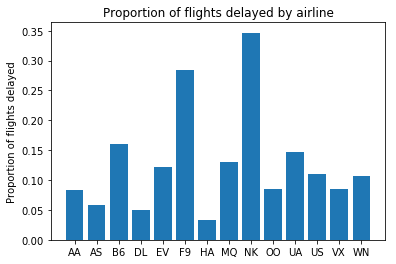

In [12]:
#do delays vary across airlines

#proportion of flight delayed
byairline = flighttrain.groupby('AIRLINE')
airline_props=byairline['DELAY_OR_NOT'].mean()
plt.bar(range(len(airline_props)),airline_props,tick_label=list(airline_props.index))
plt.ylabel('Proportion of flights delayed')
plt.title('Proportion of flights delayed by airline')
plt.show()

Wow, it looks like NK is by far the worst (Spirit Airlines) with almost 40% of flights delayed, while HA, AS, and DL have low rates of delay (Hawaiian, Alaska, and Delta).

(2064, 18)


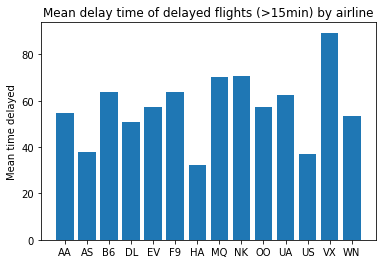

In [13]:
#mean length of delay when delayed
delayedflightstrain=flighttrain[flighttrain['DELAY_OR_NOT']==1]
print(delayedflightstrain.shape)

byairline2 = delayedflightstrain.groupby('AIRLINE')
airline_means=byairline2['ARRIVAL_DELAY'].mean()
plt.bar(range(len(airline_means)),airline_means,tick_label=list(airline_means.index))
plt.ylabel('Mean time delayed')
plt.title('Mean delay time of delayed flights (>15min) by airline')
plt.show()

Given a flight is delayed, it does not look like there is much difference across the airlines, but it appears maybe HA and AS (Hawaiian and Alaska again) does a little bit better than the rest and VX (Virgin Airlines) does the worst.

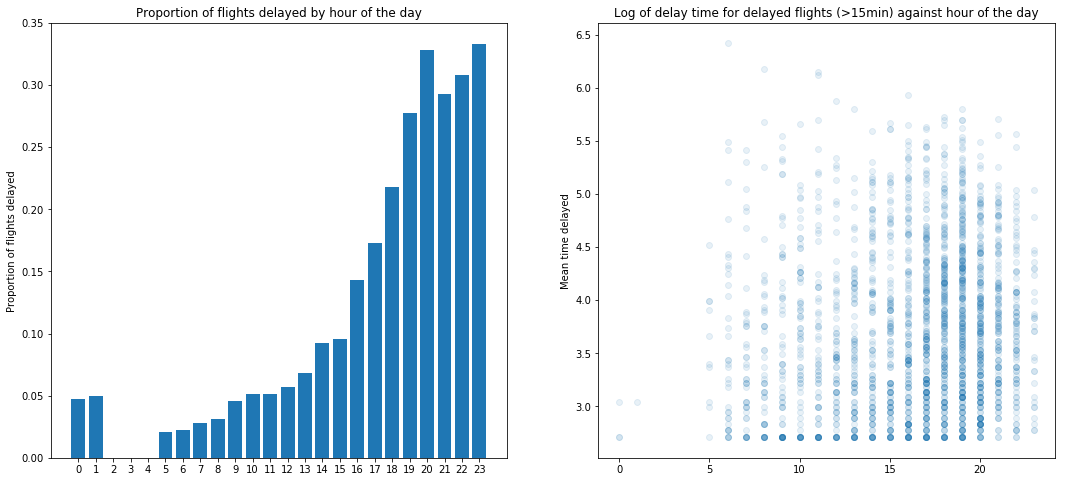

In [14]:
# do delays vary across time of departure, 
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

plt.subplot(1, 2, 1)
bytime = flighttrain.groupby('SCHED_DEP_HOUR')
time_props=bytime['DELAY_OR_NOT'].mean()
plt.bar(range(len(time_props)),time_props,tick_label=list(time_props.index))
plt.ylabel('Proportion of flights delayed')
plt.title('Proportion of flights delayed by hour of the day')


plt.subplot(1, 2, 2)
byairline2 = delayedflightstrain.groupby('SCHED_DEP_HOUR')
airline_means=byairline2['ARRIVAL_DELAY'].mean()
#plt.bar(range(len(airline_means)),airline_means,tick_label=list(airline_means.index))
plt.scatter(delayedflightstrain['SCHED_DEP_HOUR'],np.log(delayedflightstrain['ARRIVAL_DELAY']),alpha=.1)
plt.ylabel('Mean time delayed')
plt.title('Log of delay time for delayed flights (>15min) against hour of the day')

plt.show()
#print(np.transpose(bytime['DELAY_OR_NOT'].count()),byairline2['ARRIVAL_DELAY'].count())

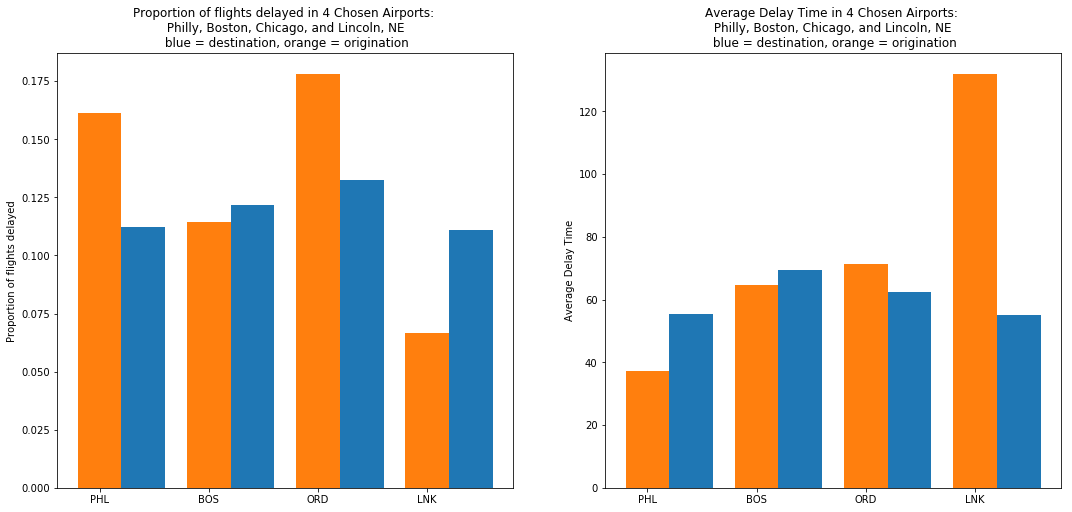

In [15]:
#do delays vary across airport (do, at the very least, Chicago (ORD), Boston (BOS), and your favorite other airport)
byorigairport = flighttrain.groupby('ORIGIN_AIRPORT')
bydestairport = flighttrain.groupby('DESTINATION_AIRPORT')

byorigairport2 = delayedflightstrain.groupby('ORIGIN_AIRPORT')
bydestairport2 = delayedflightstrain.groupby('DESTINATION_AIRPORT')

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

plt.subplot(1, 2, 1)
keepairports=['PHL','BOS','ORD','LNK']
indices=[1,2,3,4]
plt.bar([x+.2 for x in indices],bydestairport['DELAY_OR_NOT'].mean()[keepairports],tick_label=keepairports,width=.4)
plt.bar([x-.2 for x in indices],byorigairport['DELAY_OR_NOT'].mean()[keepairports],tick_label=keepairports,width=.4)
plt.ylabel('Proportion of flights delayed')
plt.title('Proportion of flights delayed in 4 Chosen Airports: \n Philly, Boston, Chicago, and Lincoln, NE \n blue = destination, orange = origination')

plt.subplot(1, 2, 2)
plt.bar([x+.2 for x in indices],byorigairport2['ARRIVAL_DELAY'].mean()[keepairports],tick_label=keepairports,width=.4)
plt.bar([x-.2 for x in indices],bydestairport2['ARRIVAL_DELAY'].mean()[keepairports],tick_label=keepairports,width=.4)
plt.ylabel('Average Delay Time')
plt.title('Average Delay Time in 4 Chosen Airports: \n Philly, Boston, Chicago, and Lincoln, NE \n blue = destination, orange = origination')
plt.show()


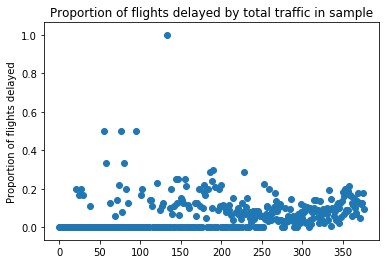

In [16]:
bytraffic = flighttrain.groupby('FLIGHT_COUNT')
traffic_props=bytraffic['DELAY_OR_NOT'].mean()
plt.scatter(range(len(traffic_props)),traffic_props)
plt.ylabel('Proportion of flights delayed')
plt.title('Proportion of flights delayed by total traffic in sample')

Note, this scatterplot has a whole lot of spread on the left, and a lot less spread on the right.  It does suggest that a quadratic relationship may exist (really, it should be logistic in nature).

---

4..(20pts) Build a classification model that classifies delays according to `DELAY_OR_NOT`. This is an unbalanced dataset, thus consider the appropriate performance metric when reporting your results. 

In [17]:
flighttrain.DAY_OF_WEEK = flighttrain.DAY_OF_WEEK.astype(str)
flighttrain.MONTH = flighttrain.MONTH.astype(str)


//anaconda/envs/py3l/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
#Fitting an unpenalized logistic regression

# Using all predictors is a terrible idea.  Don't need both indicators for airport, and variables that are 
# static for them (like how we defined FLIGHT_COUNT).  But let's see how it does.
logitm = sk.linear_model.LogisticRegression(C = 1000000)
logitm.fit (X_train, y_train)


LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
#Fitting a Lasso-like penalized logistic regression to take care of the overfitted model

# Create logistic regression object
logitCV = sk.linear_model.LogisticRegressionCV(Cs = 20,penalty='l1',solver='liblinear', scoring='roc_auc')
logitCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [20]:
# Decision Tree Classifier
dec_tree = DecisionTreeClassifier()
depths = {'max_depth': list(range(2,15))}
dec_tree_grid = sk.model_selection.GridSearchCV(dec_tree, depths, cv=5, scoring='roc_auc')
dec_tree_grid.fit(X_train,y_train)
best_depth = max([(s,d) for s,d in zip(dec_tree_grid.cv_results_['mean_test_score'],list(range(2,15)))],key=lambda x: x[0])[1]
dec_tree_best = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

In [21]:
#score the two models on the ttrain and test est set
print(sk.metrics.roc_auc_score(y_train, logitCV.predict_proba(X_train)[:,1]))
print(sk.metrics.roc_auc_score(y_train, logitm.predict_proba(X_train)[:,1]))
print(sk.metrics.roc_auc_score(y_train, dec_tree_best.predict_proba(X_train)[:,1]))

0.799734070083
0.570133771822
0.759070444915


In [22]:
print(sk.metrics.roc_auc_score(y_test, logitCV.predict_proba(X_test)[:,1]))
print(sk.metrics.roc_auc_score(y_test, logitm.predict_proba(X_test)[:,1]))
print(sk.metrics.roc_auc_score(y_test, dec_tree_best.predict_proba(X_test)[:,1]))

0.781685342117
0.555077258859
0.746359236072


Based on the AUCs for the test set listed above, it looks like the L1 penalized Logistic Regression model (hyperparameter chosen through cross-validation) is the best choice: it has an AUC score of 0.78 while the decision tree's AUC is around 0.75, and the standard logistic regression has an AUC of about 0.55 (this is so bad because it is WAY overfit and the model has too many parameters/variables that are redundant: for example 'FLIGHT_COUNT' is static across airpot, so it is not needed at all).

---

5..(5pts) Given your model, comment on the importance of factors as related to whether a flight is delayed.

In [23]:
# The coefficients that are non-zero in the training set
#np.concatenate((X_train.columns[logitCV.coef_[0,:]>0],np.transpose(logitCV.coef_[:,logitCV.coef_[0,:]>0])), axis=0)
#len([])
betas = np.transpose(logitCV.coef_[:,logitCV.coef_[0,:]>0])
features = X_train.columns[logitCV.coef_[0,:]>0]

signif_betas=pd.DataFrame([features, betas])
signif_betas

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,DISTANCE,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_BDL,ORIGIN_AIRPORT_BOI,ORIGIN_AIRPORT_BOS,...,DESTINATION_AIRPORT_PBI,DESTINATION_AIRPORT_PHL,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_PSP,DESTINATION_AIRPORT_RHI,DESTINATION_AIRPORT_SAN,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_SJU,DESTINATION_AIRPORT_TPA,DESTINATION_AIRPORT_TUS
1,[0.0013312971535],[0.213106040728],[0.0128271718374],[1.68075564832e-05],[0.72312737933],[1.62780922685],[0.392291122597],[0.042250587996],[0.270698582697],[0.340996173406],...,[0.425654960694],[0.313562135435],[0.269820809057],[0.359914286792],[0.772810176206],[0.158951930548],[1.17469723309],[0.364809860535],[0.57254116115],[0.288153373916]


Lasso gives us an automatic sense of which variables are important and which are not.  In the above, we see that distance a flight travels, scheduled time of departure, scheduled time of arrival, size of the airport, whether the previous flight was delayed, and several different origination and desitination airports are important features (we are left with 109 non-zero beta coefficients).  Alterntively, we could have performed created bootstrap samples to determine which coefficients were different from zero.

---

6..(5pts) Evaluate your model(s) on your test set, and finally provide a visual to show which airlines are predicted to have the most delays using all the data excluding the training and test set. 

In [24]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc
import seaborn.apionly as sns

def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 4))
            ax.annotate(("t = "+threshold), (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")


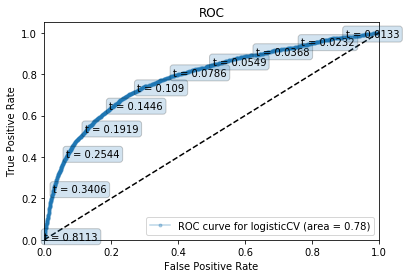

In [25]:
#use the labeled roc curve to get a sense of what threshold should be chosen. 
#Here we will select a threshould of about 0.2 to make the classification
ax=make_roc("logisticCV",logitCV, y_test, X_test, labe=500, skip=5)

In [26]:
#let's perform the classification for the remaining observations, 
#and we see we classify about 15% of those data to be delayed, which is fairly close
#to what is actually observed.
yhats_else = 1*(logitCV.predict_proba(X_else)[:,1]>=0.2)
flightelse['yhats']=yhats_else
np.mean(yhats_else)

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0.15113191736356138

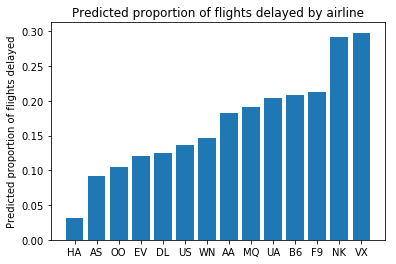

In [27]:
#now let's create a visual to see which airlines are predicted to be the worst:

byairlineelse = flightelse.groupby('AIRLINE')
airline_delays_predicted = byairlineelse['yhats'].mean()
airline_delays_predicted_sort = airline_delays_predicted.sort_values()

plt.bar(range(len(airline_delays_predicted_sort)),airline_delays_predicted_sort,tick_label=list(airline_delays_predicted_sort.index))
plt.ylabel('Predicted proportion of flights delayed')
plt.title('Predicted proportion of flights delayed by airline')
plt.show()

Not surprisingly, our model predicts that Hawaiian airlines will have the lowest rate of delays, while Virgin and Spirit will have the highest rate of delays (which matches the EDA from ealier).

---

7..(15pts) Build a regression model that predicts the length of delay (on the log scale) given that a flight is truly delayed.


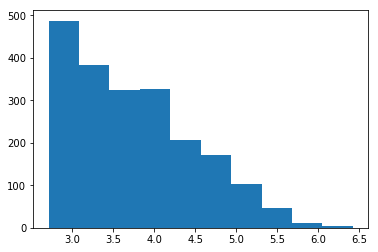

In [28]:
#let's start by creating the data sets of interest for this problem

delayed_train = flighttrain[flighttrain['DELAY_OR_NOT']==1] 
delayed_test = flighttest[flighttest['DELAY_OR_NOT']==1] 

X_train2 = X_train[flighttrain['DELAY_OR_NOT']==1]
X_test2 = X_test[flighttest['DELAY_OR_NOT']==1] 

y_train2 = np.log(delayed_train['ARRIVAL_DELAY'])
y_test2 = np.log(delayed_test['ARRIVAL_DELAY'])

#plotting the histogram just to see what we are dealing with
hist7=plt.hist(y_train2)

In [29]:
lassoCV_model = sk.linear_model.LassoCV(n_alphas = 100)
lassoCV_model.fit(X_train2, y_train2)

linear_model = sk.linear_model.LinearRegression()
linear_model.fit(X_train2, y_train2)
print(linear_model.score(X_train2,y_train2),lassoCV_model.score(X_train2,y_train2))

0.257880783692 0.0221741775963


In [30]:
 print(linear_model.score(X_test2,y_test2),lassoCV_model.score(X_test2,y_test2))


-1.81173308094e+13 0.019668832415


Based on the model shown above, we see that the Lasso Regression model has an $R^2$ of just 0.0197 in the test set.  Surely we can do better.

---

8..(20pts) Write a report (in the last markdown cell in your notebook with your findings (without code)). Describe the main design decisions you have made with justifications. Clearly explain your methodology and results. This should not be more than 300 words. You may use up to 5 diagrams.

Before fitting any models, several decisions had to be made in order to wrangle the data:
1. We decided to drop any variables that were actual derivatives of delays or could not be measured before heading to the airport to catch a flight.  
2. We subsampled only 20,000 observations into the training and testing sets (40K total) as this was large enough to encapsulate the most important predcictors but small enough to handle.
3. All EDA and models were performed only on the train set as to not bias results in evaluation using the test set.
4. When fitting models, we decided to not standardize the variables so that we could directly interpret the coefficients (for ease of interpretation).  This may have led to worse-performing models overall.

In order to predict which flights will be delayed in 2015, we considered 3 models: standard logistic regression, L1-penalized logistic regression (with hyperparameter tuned through 5-fold crosvalidation), and a classification tree.  The penalized logistic regression performed the best both in the train and test sets, with an AUC score of about 0.78.  We decided to set a threshould of 0.20 for classification because this led to a similar delay rate as what was truly deserved (flagged more flights as delayed since false negatives were worse from a user perspective).  

We also fit a Lasso regression (and considered an unpenalized linear regression) to predict the variables .  We again used only the subsample of data to train and evaluate the model (leading to an even smaller set of data to fit models, about 2,000 in each since about 10% of flights were delayed in the datasets).  Unfortunately we were only able to get an $R^2$ of about 2% in the test set.  With more time, we'd like to improve this model, and certainly would enlarge the data set used for both training and testing.


**Note: these data oversampled the delayed flights and undersampled the on-time flights: thanks god!  I would hope that Spirit airlines does not truly have nearly a 30% delay rate!!!**

### 209 Additional questions
(1). (10pts) Engineer two additional features that will help improve the classification model's performance.

We have one, engineered a little earlier

In [31]:
features209

{'PREVIOUS_TAIL_DELAYED': 604157    0.0
 435627    0.0
 475811    0.0
 253510    0.0
 193075    0.0
 209376    0.0
 648829    0.0
 159885    0.0
 98383     0.0
 389980    0.0
 72691     0.0
 61095     0.0
 347597    0.0
 521103    0.0
 33394     0.0
 549022    0.0
 427991    0.0
 263024    0.0
 554710    0.0
 488046    0.0
 272684    0.0
 744739    0.0
 760167    0.0
 615859    0.0
 275714    0.0
 577767    0.0
 647225    0.0
 638800    0.0
 17133     0.0
 573076    0.0
          ... 
 715169    0.0
 98618     0.0
 307712    0.0
 43750     0.0
 371047    0.0
 191988    0.0
 462995    0.0
 451491    0.0
 483006    0.0
 750547    0.0
 526059    0.0
 323341    0.0
 493054    0.0
 550471    0.0
 441112    0.0
 697682    0.0
 274877    1.0
 187359    0.0
 570546    0.0
 183273    0.0
 351783    0.0
 727492    0.0
 589039    0.0
 290977    0.0
 101540    0.0
 344004    0.0
 58540     0.0
 558154    0.0
 75070     0.0
 516351    0.0
 Name: DELAY_OR_NOT, Length: 804941, dtype: float64}

The second one is taken and modified from Camilo Frosco's submission.

We will try a feature from his submission: The busyness of the destination airport on the weekday of the flight.

In [37]:
dadwgb = flightdata2.groupby(['DESTINATION_AIRPORT', 'DAY_OF_WEEK']).DATE.count()
rsdict={}
rs = dadwgb.reset_index()
rskeyzip = zip(rs.DESTINATION_AIRPORT.values, rs.DAY_OF_WEEK.values)
rsvals = rs.DATE.values
ind = 0

for ktuple in rskeyzip:
    rsdict[ktuple] = rsvals[ind]
    ind = ind + 1
rsdict

{('10135', 1): 1,
 ('10135', 2): 4,
 ('10135', 3): 1,
 ('10135', 4): 9,
 ('10135', 5): 8,
 ('10135', 6): 1,
 ('10135', 7): 6,
 ('10136', 1): 8,
 ('10136', 2): 5,
 ('10136', 3): 6,
 ('10136', 4): 4,
 ('10136', 5): 7,
 ('10136', 6): 3,
 ('10136', 7): 1,
 ('10140', 1): 41,
 ('10140', 2): 40,
 ('10140', 3): 38,
 ('10140', 4): 37,
 ('10140', 5): 49,
 ('10140', 6): 36,
 ('10140', 7): 30,
 ('10141', 1): 2,
 ('10141', 2): 2,
 ('10141', 4): 2,
 ('10141', 5): 3,
 ('10141', 6): 1,
 ('10141', 7): 2,
 ('10146', 2): 2,
 ('10146', 3): 3,
 ('10146', 4): 3,
 ('10146', 5): 1,
 ('10146', 6): 3,
 ('10146', 7): 2,
 ('10154', 1): 1,
 ('10154', 6): 2,
 ('10155', 1): 6,
 ('10155', 2): 6,
 ('10155', 3): 6,
 ('10155', 4): 3,
 ('10155', 5): 3,
 ('10155', 6): 3,
 ('10155', 7): 1,
 ('10157', 1): 2,
 ('10157', 2): 2,
 ('10157', 3): 2,
 ('10157', 4): 4,
 ('10157', 6): 4,
 ('10157', 7): 1,
 ('10158', 1): 3,
 ('10158', 2): 4,
 ('10158', 3): 3,
 ('10158', 4): 5,
 ('10158', 5): 6,
 ('10158', 6): 5,
 ('10158', 7): 3,
 ('

In [39]:
das = flightdata2.DESTINATION_AIRPORT.values
dws = flightdata2.DAY_OF_WEEK.values
dcounts = np.zeros(das.shape[0], dtype='int')
ind = 0
for da, dw in zip(das, dws):
    dcounts[ind] = rsdict[(da,dw)]
    ind = ind + 1

features209['DESTINATION_BUSYNESS'] = pd.Series(dcounts, index=flightdata2.index)

In [40]:
features209['DESTINATION_BUSYNESS'].shape

(804941,)

In [41]:
df209one = pd.DataFrame.from_dict(features209)
df209one.head()

,DESTINATION_BUSYNESS,PREVIOUS_TAIL_DELAYED
604157,125,0.0
435627,7479,0.0
475811,2789,0.0
253510,632,0.0
193075,291,0.0


In [43]:
df209one = df209one.join(flightdata2)

In [44]:
N = 20000
flighttrain209 = df209one.iloc[0:N]
flighttest209 = df209one.iloc[N:(2*N)]
X209 = df209one[['DISTANCE','SCHEDULED_TIME','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT', 'DESTINATION_BUSYNESS', 'PREVIOUS_TAIL_DELAYED']]


dummy_vars209 = pd.get_dummies(df209one[['MONTH','DAY_OF_WEEK','ORIGIN_AIRPORT','DESTINATION_AIRPORT']])
X209 = X209.join(dummy_vars209.drop(['MONTH','DAY_OF_WEEK'],axis=1))
X_train209 = X209.iloc[0:N]
X_test209 = X209.iloc[N:(2*N)]

flightelse209 = df209one.iloc[(2*N):df209one.shape[0]]
X_else209 = X209.iloc[(2*N):df209one.shape[0]]

In [46]:
#Fitting a Lasso-like penalized logistic regression to take care of the overfitted model

# Create logistic regression object
logitCV209one = sk.linear_model.LogisticRegressionCV(Cs = 20,penalty='l1',solver='liblinear', scoring='roc_auc')
logitCV209one.fit(X_train209, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [47]:
print(sk.metrics.roc_auc_score(y_train, logitCV209one.predict_proba(X_train209)[:,1]))

print(sk.metrics.roc_auc_score(y_test, logitCV209one.predict_proba(X_test209)[:,1]))



0.806004116056
0.78833658064


The AUCs are improved a tiny bit. We leave it as an exercise to try the other models.

(2). (5pts) Add one additional feature from a data source not given to you.  Do this only after you complete the rest of the exam.

We will create a feature which tells us which airports are hubs or regional centers. This data is taken from wikipedia. (copied by hand)

In [48]:
hubdict = dict(
    UA = ['IAD', 'LAX', 'SFO', 'DEN', 'ORD', 'EWR', 'IAH'],
    AA = ['MIA', 'ORD', 'JFK', 'CLT', 'PHL', 'DFW', 'DCA', 'PHX', 'LAX'],
    US = ['CLT', 'PHL', 'DCA', 'PHX', 'LAX'],
    F9 = ['MCI', 'MKE', 'DEN', 'ORD', 'CVG', 'TTN', 'CLE'],
    B6 = ['FLL', 'BOS', 'JFK'],
    OO = [],
    AS = ['ANC', 'LAX', 'PDX', 'SEA'],
    NK = ['FLL', 'ORD', 'DTW'],
    WN = ['ATL', 'MDW', 'BWI', 'DAL', 'STL', 'LAS', 'SAN', 'DEN', 'MCO', 'TPA', 'PHX', 'LAX'],
    DL = ['LAX', 'ATL', 'CVG', 'BOS', 'DTW', 'MSP', 'JFK', 'LGA', 'SLC', 'SEA'],
    EV = [],
    HA = ['HNL', 'OGG'],
    MQ = [],
    VX = ['SFO', 'DAL', 'LAX']
)

In [49]:
hubs = set()
for airline in hubdict:
    airlinehubs = set(hubdict[airline])
    hubs = hubs.union(airlinehubs)
hubs

{'ANC',
 'ATL',
 'BOS',
 'BWI',
 'CLE',
 'CLT',
 'CVG',
 'DAL',
 'DCA',
 'DEN',
 'DFW',
 'DTW',
 'EWR',
 'FLL',
 'HNL',
 'IAD',
 'IAH',
 'JFK',
 'LAS',
 'LAX',
 'LGA',
 'MCI',
 'MCO',
 'MDW',
 'MIA',
 'MKE',
 'MSP',
 'OGG',
 'ORD',
 'PDX',
 'PHL',
 'PHX',
 'SAN',
 'SEA',
 'SFO',
 'SLC',
 'STL',
 'TPA',
 'TTN'}

In [51]:
hubdfdict={}
hubdfdict['ORIGIN_HUB'] = flightdata2.ORIGIN_AIRPORT.isin(hubs)*1
hubdfdict['DESTINATION_HUB'] = flightdata2.DESTINATION_AIRPORT.isin(hubs)*1
dfhubs = pd.DataFrame.from_dict(hubdfdict)
dfhubs.head()

,DESTINATION_HUB,ORIGIN_HUB
604157,0,1
435627,1,0
475811,1,1
253510,1,1
193075,0,0


In [52]:
df209two = df209one.join(dfhubs)

In [53]:
N = 20000
flighttrain209two = df209two.iloc[0:N]
flighttest209two = df209two.iloc[N:(2*N)]
X209two = df209two[['DISTANCE','SCHEDULED_TIME','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT', 'DESTINATION_BUSYNESS', 'PREVIOUS_TAIL_DELAYED', 'DESTINATION_HUB', 'ORIGIN_HUB']]


dummy_vars209two = pd.get_dummies(df209two[['MONTH','DAY_OF_WEEK','ORIGIN_AIRPORT','DESTINATION_AIRPORT']])
X209two = X209two.join(dummy_vars209two.drop(['MONTH','DAY_OF_WEEK'],axis=1))
X_train209two = X209two.iloc[0:N]
X_test209two = X209two.iloc[N:(2*N)]

flightelse209two = df209two.iloc[(2*N):df209two.shape[0]]
X_else209two = X209two.iloc[(2*N):df209two.shape[0]]

In [54]:
#Fitting a Lasso-like penalized logistic regression to take care of the overfitted model

# Create logistic regression object
logitCV209two = sk.linear_model.LogisticRegressionCV(Cs = 20,penalty='l1',solver='liblinear', scoring='roc_auc')
logitCV209two.fit(X_train209two, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [55]:
print(sk.metrics.roc_auc_score(y_train, logitCV209two.predict_proba(X_train209two)[:,1]))

print(sk.metrics.roc_auc_score(y_test, logitCV209two.predict_proba(X_test209two)[:,1]))




0.80623566717
0.788601740576


The improvement is even more marginal. Feature engineering is tough, and this problem needs far greater study.

In [60]:
flighttrain209two.shape, flighttest209two.shape

((20000, 22), (20000, 22))

In [61]:
delayed_train209two = flighttrain209two[flighttrain209two['DELAY_OR_NOT']==1] 
delayed_test209two = flighttest209two[flighttest209two['DELAY_OR_NOT']==1] 

X_train2_209 = X_train209two[flighttrain209two['DELAY_OR_NOT']==1]
X_test2_209 = X_test209two[flighttest209two['DELAY_OR_NOT']==1] 

y_train2_209 = np.log(delayed_train209two['ARRIVAL_DELAY'])
y_test2_209 = np.log(delayed_test209two['ARRIVAL_DELAY'])

In [63]:
lassoCV_model209 = sk.linear_model.LassoCV(n_alphas = 100)
lassoCV_model209.fit(X_train2_209, y_train2_209)

print("Train", lassoCV_model209.score(X_train2_209,y_train2_209))
print("Test", lassoCV_model209.score(X_test2_209,y_test2_209))



Train 0.023857161446
Test 0.022252417352


The improvement in regression is equally marginal.

## Deliverable: 
A well presented notebook with well structured and documented code to answer questions 1-7 (plus additional questions for 209 students) with brief explanations and/or clarifications (10pts for overall presentation). The last cell should contain the report for question 8.



## Hints
1. For the classification model, an AUC of approximately 0.6 should be your base model. 
2. $R^2>0.03$ for the regression is good, $R^2>0.05$ very good, and $R^2>0.1$ is impressive (measured on the log scale). 